# 제품 이상여부 판별 프로젝트


### 1. 데이터 불러오기


### 필수 라이브러리


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [ ]:
ROOT_DIR = "data"
RANDOM_STATE = 110


# Load data
df = pd.read_csv('/content/drive/MyDrive/Aimers_생산불량/new_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Aimers_생산불량/new_test.csv')
# Load data
#df = pd.read_csv('data/train.csv')
#test_df = pd.read_csv('data/test.csv')

In [ ]:
df.head(5)
print(df.shape)
#40506행, 464열

(40506, 464)


###3개 컬럼 결측치 고민

In [ ]:
#결측치 제거 - 모든 행이 결측치면 삭제
dr=df.isnull().sum().sort_values()[-281:].index
df.drop(columns=dr,inplace=True)
test_df.drop(columns=dr,inplace=True)

In [ ]:
#고유값이 하나면 모델 학습에 영향을 주지 못할 것이라 판단, 삭제
dr_0=df.nunique().sort_values()[:64].index
df.drop(columns=dr_0,inplace=True)
test_df.drop(columns=dr_0,inplace=True)

In [ ]:
#남은 컬럼은 119 컬럼
df.head(5)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,428.0,243.7,243.7,243.7,114.612,19.9,7.0,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.6,7.0,185,1,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,1324.2,243.5,243.5,243.5,114.612,19.8,10.0,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,1324.2,243.5,243.5,243.5,85.000,19.9,12.0,268,1,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,428.0,243.7,243.7,243.7,85.000,19.7,8.0,121,1,Normal


## 주요 변수 분별

In [ ]:
#중복 컬럼 삭제
dr2=[
 'Model.Suffix_AutoClave',
 'Workorder_AutoClave',

 'Equipment_Fill1',
 'Model.Suffix_Fill1',
 'Workorder_Fill1',
 'Production Qty Collect Result_Fill1',
 'Receip No Collect Result_Fill1',

 'Equipment_Fill2',
 'Model.Suffix_Fill2',
 'Workorder_Fill2',
 'Production Qty Collect Result_Fill2',
 'Receip No Collect Result_Fill2'
 #,'PalletID Collect Result_Fill2'  #######  추가
 ]
df.drop(columns=dr2,inplace=True)
test_df.drop(columns=dr2,inplace=True)

In [ ]:
df['target']=np.where(df['target']=='AbNormal',1,0)
test_df['target']=np.where(test_df['target']=='AbNormal',1,0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
'''
for i in range(0,140,20):
  fig,axs=plt.subplots(5,4,figsize=(20,20)) #세로 *가로, 한번에 4개의 그래프를 그리겠다.
  fig.suptitle('Abnormal Dist')

  for i,j in enumerate(df.select_dtypes('number').columns[i:i+20],1): #5번 돌리기..
    plt.subplot(5,4,i)
    sns.distplot(df.loc[df['target'] == 0, j], bins=20, color='skyblue', label='normal')
    sns.distplot(df.loc[df['target'] == 1, j], bins=20, color='red', label='outlier')
    #plt.title(j)

  plt.show()
'''

"\nfor i in range(0,140,20):\n  fig,axs=plt.subplots(5,4,figsize=(20,20)) #세로 *가로, 한번에 4개의 그래프를 그리겠다.\n  fig.suptitle('Abnormal Dist')\n\n  for i,j in enumerate(df.select_dtypes('number').columns[i:i+20],1): #5번 돌리기..\n    plt.subplot(5,4,i)\n    sns.distplot(df.loc[df['target'] == 0, j], bins=20, color='skyblue', label='normal')\n    sns.distplot(df.loc[df['target'] == 1, j], bins=20, color='red', label='outlier')\n    #plt.title(j)\n\n  plt.show()\n"

In [ ]:
#dr3 재정
dr3=['CURE SPEED Collect Result_Dam','DISCHARGED SPEED OF RESIN Collect Result_Dam','CURE START POSITION X Collect Result_Dam','CURE START POSITION Θ Collect Result_Dam','Head Zero Position Z Collect Result_Dam','Head Zero Position Y Collect Result_Dam','PalletID Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1','HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2','HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2','Machine Tact time Collect Result_Fill1','Head Zero Position Y Collect Result_Dam'
    ,'Head Purge Position Z Collect Result_Dam','Head Clean Position Z Collect Result_Dam'

    #  파생변수 시도
    #,'3rd Pressure Unit Time_AutoClave','THICKNESS 2 Collect Result_Dam','2nd Pressure Collect Result_AutoClave','Stage3 Line3 Distance Speed Collect Result_Dam','3rd Pressure Collect Result_AutoClave'
]
df.drop(columns=dr3,inplace=True)
test_df.drop(columns=dr3,inplace=True)

In [ ]:
#dr4 - circle, line값 같음. 아예
dr4=[
       'Stage1 Circle2 Distance Speed Collect Result_Dam',
       'Stage1 Circle3 Distance Speed Collect Result_Dam',
       'Stage1 Circle4 Distance Speed Collect Result_Dam',

       'Stage1 Line2 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',

       'Stage2 Circle2 Distance Speed Collect Result_Dam',
       'Stage2 Circle3 Distance Speed Collect Result_Dam',
       'Stage2 Circle4 Distance Speed Collect Result_Dam',

       'Stage2 Line2 Distance Speed Collect Result_Dam',
       'Stage2 Line3 Distance Speed Collect Result_Dam',
       'Stage2 Line4 Distance Speed Collect Result_Dam',

       'Stage3 Circle2 Distance Speed Collect Result_Dam',
       'Stage3 Circle3 Distance Speed Collect Result_Dam',
       'Stage3 Circle4 Distance Speed Collect Result_Dam',

       'Stage3 Line2 Distance Speed Collect Result_Dam',
       'Stage3 Line4 Distance Speed Collect Result_Dam',]

df.drop(columns=dr4,inplace=True)
test_df.drop(columns=dr4,inplace=True)

In [ ]:
'''성능 되려 내려감
#dr4 - circle, line값 같음. 아예 - 확인 ..
d=[
      # 'Stage1 Circle1 Distance Speed Collect Result_Dam',
       'Stage1 Line1 Distance Speed Collect Result_Dam',
       #'Stage2 Circle1 Distance Speed Collect Result_Dam',
       'Stage2 Line1 Distance Speed Collect Result_Dam',
       #'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'Stage3 Line1 Distance Speed Collect Result_Dam',
       'Stage3 Line3 Distance Speed Collect Result_Dam'

 ]

df.drop(columns=d,inplace=True)
test_df.drop(columns=d,inplace=True)
'''

"성능 되려 내려감\n#dr4 - circle, line값 같음. 아예 - 확인 ..\nd=[\n      # 'Stage1 Circle1 Distance Speed Collect Result_Dam',\n       'Stage1 Line1 Distance Speed Collect Result_Dam',\n       #'Stage2 Circle1 Distance Speed Collect Result_Dam',\n       'Stage2 Line1 Distance Speed Collect Result_Dam',\n       #'Stage3 Circle1 Distance Speed Collect Result_Dam',\n       'Stage3 Line1 Distance Speed Collect Result_Dam',\n       'Stage3 Line3 Distance Speed Collect Result_Dam'\n\n ]\n\ndf.drop(columns=d,inplace=True)\ntest_df.drop(columns=d,inplace=True)\n"

In [ ]:
df.shape

(40506, 76)

###Try : 밑에 3차원보단 파생변수 시도

In [ ]:
#train

#합계/평균/최대/최소/표준편차/분산/비율
#Dam
df['MEAN DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
df['STD DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
df['SUM DISCHARGED TIME OF RESIN_Dam']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

df['MEAN Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
df['STD Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
df['SUM Dispense Volume_Dam']=df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
df['DIV Dispense Volume(Stage1)_Dam']=df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/df['Dispense Volume(Stage1) Collect Result_Dam']
df['DIV Dispense Volume(Stage2)_Dam']=df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/df['Dispense Volume(Stage2) Collect Result_Dam']
df['DIV Dispense Volume(Stage3)_Dam']=df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/df['Dispense Volume(Stage3) Collect Result_Dam']

#Fill1
#합계/평균/최대/최소/표준편차/분산/비율

df['MEAN DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
df['STD DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
df['SUM DISCHARGED TIME OF RESIN_Fill1']=df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

df['MEAN Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
df['STD Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
df['SUM Dispense Volume_Fill1']=df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
df['DIV Dispense Volume(Stage1)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/df['Dispense Volume(Stage1) Collect Result_Fill1']
df['DIV Dispense Volume(Stage2)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/df['Dispense Volume(Stage2) Collect Result_Fill1']
df['DIV Dispense Volume(Stage3)_Fill1']=df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/df['Dispense Volume(Stage3) Collect Result_Fill1']

#Thickness(변화가 있는지도 비율로 보면 좋을듯)

df['SUM THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
df['MEAN THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
df['STD THICKNESS_Dam']=df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

df['DIV1 THICKNESS_Dam']=df['THICKNESS 2 Collect Result_Dam']/df['THICKNESS 1 Collect Result_Dam']
df['DIV2 THICKNESS_Dam']=df['THICKNESS 3 Collect Result_Dam']/df['THICKNESS 2 Collect Result_Dam']

#1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
df['SUM Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
df['MEAN Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
df['STD Pressure_AutoClave']=df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

df['DIV1 Pressure_AutoClave']=df['2nd Pressure Collect Result_AutoClave']/df['1st Pressure Collect Result_AutoClave']
df['DIV2 Pressure_AutoClave']=df['3rd Pressure Collect Result_AutoClave']/df['2nd Pressure Collect Result_AutoClave']

In [ ]:
#train

#합계/평균/최대/최소/표준편차/분산/비율
#Dam
test_df['MEAN DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)
test_df['STD DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].std(axis=1)
test_df['SUM DISCHARGED TIME OF RESIN_Dam']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

test_df['MEAN Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].mean(axis=1)
test_df['STD Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].std(axis=1)
test_df['SUM Dispense Volume_Dam']=test_df[['Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
test_df['DIV Dispense Volume(Stage1)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']/test_df['Dispense Volume(Stage1) Collect Result_Dam']
test_df['DIV Dispense Volume(Stage2)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']/test_df['Dispense Volume(Stage2) Collect Result_Dam']
test_df['DIV Dispense Volume(Stage3)_Dam']=test_df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']/test_df['Dispense Volume(Stage3) Collect Result_Dam']

#Fill1
#합계/평균/최대/최소/표준편차/분산/비율

test_df['MEAN DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].mean(axis=1)
test_df['STD DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].std(axis=1)
test_df['SUM DISCHARGED TIME OF RESIN_Fill1']=test_df[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']].sum(axis=1)

test_df['MEAN Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].mean(axis=1)
test_df['STD Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].std(axis=1)
test_df['SUM Dispense Volume_Fill1']=test_df[['Dispense Volume(Stage1) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Fill1']].sum(axis=1)

#비율 - 같은 용량이 나오는 데에 걸리는 시간
test_df['DIV Dispense Volume(Stage1)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']/test_df['Dispense Volume(Stage1) Collect Result_Fill1']
test_df['DIV Dispense Volume(Stage2)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']/test_df['Dispense Volume(Stage2) Collect Result_Fill1']
test_df['DIV Dispense Volume(Stage3)_Fill1']=test_df['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']/test_df['Dispense Volume(Stage3) Collect Result_Fill1']

#Thickness(변화가 있는지도 비율로 보면 좋을듯)

test_df['SUM THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].sum(axis=1)
test_df['MEAN THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].mean(axis=1)
test_df['STD THICKNESS_Dam']=test_df[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam','THICKNESS 3 Collect Result_Dam']].std(axis=1)

test_df['DIV1 THICKNESS_Dam']=test_df['THICKNESS 2 Collect Result_Dam']/test_df['THICKNESS 1 Collect Result_Dam']
test_df['DIV2 THICKNESS_Dam']=test_df['THICKNESS 3 Collect Result_Dam']/test_df['THICKNESS 2 Collect Result_Dam']

#1st/2nd/3rd - 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam''THICKNESS 3 Collect Result_Dam'
test_df['SUM Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].sum(axis=1)
test_df['MEAN Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
test_df['STD Pressure_AutoClave']=test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].std(axis=1)

test_df['DIV1 Pressure_AutoClave']=test_df['2nd Pressure Collect Result_AutoClave']/test_df['1st Pressure Collect Result_AutoClave']
test_df['DIV2 Pressure_AutoClave']=test_df['3rd Pressure Collect Result_AutoClave']/test_df['2nd Pressure Collect Result_AutoClave']

In [ ]:
#0으로 나누어 생기 nan값 0으로 처리
df['DIV1 THICKNESS_Dam']=df['DIV1 THICKNESS_Dam'].fillna(0)
df['DIV2 THICKNESS_Dam']=df['DIV2 THICKNESS_Dam'].fillna(0)

test_df['DIV1 THICKNESS_Dam']=test_df['DIV1 THICKNESS_Dam'].fillna(0)
test_df['DIV2 THICKNESS_Dam']=test_df['DIV2 THICKNESS_Dam'].fillna(0)
print(df['DIV1 THICKNESS_Dam'].isna().sum()) #확인

0


In [ ]:
#확인
'''
fig,axs=plt.subplots(3,5,figsize=(20,20)) #세로 *가로, 한번에 4개의 그래프를 그리겠다.
fig.suptitle('Abnormal Dist')

for i,j in enumerate(df.select_dtypes('number').columns[-14:],1): #5번 돌리기..
  plt.subplot(3,5,i)
  sns.distplot(df.loc[df['target'] == 0, j], bins=20, color='skyblue', label='normal')
  sns.distplot(df.loc[df['target'] == 1, j], bins=20, color='red', label='outlier')
  #plt.title(j)

plt.show()
'''

"\nfig,axs=plt.subplots(3,5,figsize=(20,20)) #세로 *가로, 한번에 4개의 그래프를 그리겠다.\nfig.suptitle('Abnormal Dist')\n\nfor i,j in enumerate(df.select_dtypes('number').columns[-14:],1): #5번 돌리기..\n  plt.subplot(3,5,i)\n  sns.distplot(df.loc[df['target'] == 0, j], bins=20, color='skyblue', label='normal')\n  sns.distplot(df.loc[df['target'] == 1, j], bins=20, color='red', label='outlier')\n  #plt.title(j)\n\nplt.show()\n"

In [ ]:
#파생변수 시각화 후 삭제 + 애매한 변수 drop

dr_new=['STD Dispense Volume_Dam','STD DISCHARGED TIME OF RESIN_Fill1','STD THICKNESS_Dam',
        'MEAN DISCHARGED TIME OF RESIN_Dam','STD DISCHARGED TIME OF RESIN_Dam','SUM DISCHARGED TIME OF RESIN_Dam'
        ,'DIV Dispense Volume(Stage1)_Dam','MEAN DISCHARGED TIME OF RESIN_Fill1','SUM Dispense Volume_Fill1','DIV Dispense Volume(Stage1)_Fill1','DIV Dispense Volume(Stage2)_Fill1','DIV Dispense Volume(Stage3)_Fill1'
        ,'SUM THICKNESS_Dam','MEAN THICKNESS_Dam','STD Pressure_AutoClave'
        ]
df.drop(columns=dr_new,inplace=True)
test_df.drop(columns=dr_new,inplace=True)

In [ ]:
##파생변수에 사용된 애들 중 상관관계 <-> FI확인해 삭제 + 3차원 안 지우던거 삭제(파생변수 안 만들거면)
dr5=[#target 상관관계도, FI도 낮은 애들, 근데 0.01 이상이라 일단 보류
     #'CURE END POSITION Θ Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2','HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
      #,'PalletID Collect Result_Fill2'

      #FI 0.01이하)
     'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
       'CURE END POSITION Θ Collect Result_Dam'  ]

df.drop(columns=dr5,inplace=True)
test_df.drop(columns=dr5,inplace=True)


#dr3에서 지우면 성능 올라가는데, 파생변수 만드려고 안 지운.. - XX
#drr=['3rd Pressure Unit Time_AutoClave','THICKNESS 2 Collect Result_Dam','2nd Pressure Collect Result_AutoClave','Stage3 Line3 Distance Speed Collect Result_Dam','3rd Pressure Collect Result_AutoClave']


In [ ]:
df.groupby('Model.Suffix_Dam')['target'].mean()

,target
Model.Suffix_Dam,
AJX75334501,0.056712
AJX75334502,0.067847
AJX75334503,0.271605
AJX75334505,0.049336
AJX75334506,0.062016
AJX75334507,0.058065
AJX75334508,0.033333


In [ ]:
  ''' 성능 되려 내려감 : 기본 이상치 비율은 0.058
  ################ TEST ########################

df.groupby('Model.Suffix_Dam')['target'].agg(['count','mean'])
model_gr={'AJX75334503':1,'AJX75334501':2,'AJX75334502':2,'AJX75334505':2,'AJX75334506':2,'AJX75334507':2,'AJX75334508':3}

#하나 유별난 거 1, 0.5이상(0.56이상):2, 0.5 이하(0.49 이하):3
#'AJX75334501':2or3(0.5이상, 0.6이상)
df['Model.Suffix_Dam'].replace(model_gr,inplace=True)
'''

" 성능 되려 내려감\n################ TEST ########################\n#이 컬럼 자체를 바꿔버리자. 3개로 나누는 게 좋을 것 같음.\n#기본 이상치 비율은 0.058\ndf.groupby('Model.Suffix_Dam')['target'].agg(['count','mean'])\nmodel_gr={'AJX75334503':1,'AJX75334501':2,'AJX75334502':2,'AJX75334505':2,'AJX75334506':2,'AJX75334507':2,'AJX75334508':3}\n#하나 유별난 거 1, 0.5이상(0.56이상):2, 0.5 이하(0.49 이하):3\n#'AJX75334501':2or3(0.5이상, 0.6이상)\ndf['Model.Suffix_Dam'].replace(model_gr,inplace=True)\n"

In [ ]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.941984
1,0.058016


In [ ]:
###### test ####### : 반영해볼까?
df.groupby(['Workorder_Dam'])['target'].agg(['count','mean']).sort_values(by='mean').tail(30)
'''
262	3	0.333333
465	13	0.384615
148	88	0.488636
443	2	0.500000
606	15	0.666667
126	15	0.866667
288	11	1.000000
582	8	1.000000
'''

'\n262\t3\t0.333333\n465\t13\t0.384615\n148\t88\t0.488636\n443\t2\t0.500000\n606\t15\t0.666667\n126\t15\t0.866667\n288\t11\t1.000000\n582\t8\t1.000000\n'

<Axes: ylabel='target'>

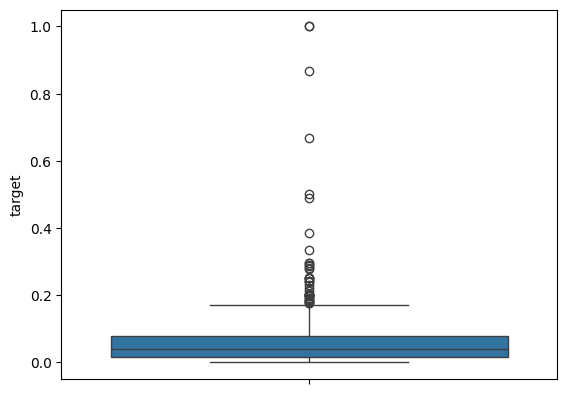

In [ ]:
import seaborn as sns
sns.boxplot(df.groupby(['Workorder_Dam'])['target'].agg('mean').sort_values())

### 언더 샘플링 or 오버샘플링 (생략)


In [ ]:
#라벨 인코딩 후 변수 분배 - 언더 샘플링
################concat class weight용! ###############

#이것도 사실 catbost쓰면 필수 아님.
'''
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() #labelencoder함수를 가져온다.

for i in df.select_dtypes('object'):
  df[i]=encoder.fit_transform(df[i]) #내가 가지고 있는 데이터에 학습시킨다
  test_df[i]=encoder.fit_transform(test_df[i])
'''


"\nfrom sklearn.preprocessing import LabelEncoder\nencoder = LabelEncoder() #labelencoder함수를 가져온다.\n\nfor i in df.select_dtypes('object'):\n  df[i]=encoder.fit_transform(df[i]) #내가 가지고 있는 데이터에 학습시킨다\n  test_df[i]=encoder.fit_transform(test_df[i])\n"

In [ ]:
X=df.drop(columns=['target'])
y=df[['target']]

In [ ]:
test_x=test_df.drop(columns=['Set ID','target'])

## 3. 모델 학습


### 모델 정의


### 모델 학습


In [ ]:
###### OPTUNA ##########33
!pip install catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
#Stratified k fold 도전

!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import optuna

pred_stacking = []
f1_scores_train = []
f1_scores_val = []
# 모델 선언

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #n_splits 변

# StratifiedKFold를 사용하여 교차 검증
for train_index, test_index in skf.split(X, y):
    train_x, val_x = X.iloc[train_index], X.iloc[test_index]
    train_y, val_y = y.iloc[train_index], y.iloc[test_index]

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
#Optuna하면 생략
#model = CatBoostClassifier(cat_features=cat_features,auto_class_weights='Balanced')


In [ ]:
######## Optuna 시도 ############# : scale pos나 auto_class 둘 중 하나만 사용 가능
import optuna
from sklearn.model_selection import cross_val_score

# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 700, 1500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        #'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5),
        #"class_weights" : class_weights,
        'eval_metric' : 'F1',


        ###필수로 넣어줘야 할 듯
        'cat_features':cat_features,
        'auto_class_weights': 'Balanced'  # 추가된 하이퍼파라미터
    }

    model = CatBoostClassifier(**params,silent=True,random_state=42) #auto_class_weights='Balanced')
    # 교차 검증을 통해 모델 평가
    scores = cross_val_score(model, train_x, train_y, cv=3, scoring='f1')
    return scores.mean()

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-21 16:30:12,089] A new study created in memory with name: no-name-d19c5c63-e6cd-4607-a42f-9115be6cb5f7
<ipython-input-71-f518d0cddc8d>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
<ipython-input-71-f518d0cddc8d>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
[I 2024-08-21 16:32:32,277] Trial 0 finished with value: 0.17412960553385112 and parameters: {'n_estimators': 1109, 'learning_rate': 0.007261695125404171, 'depth': 6, 'subsample': 0.6670578796873537, 'l2_leaf_reg': 9.475183670568654, 'border_count': 73}. Best is tri

Best trial:
  Value: 0.19200513321299562
  Params: 
    n_estimators: 1224
    learning_rate: 0.017419535324053294
    depth: 9
    subsample: 0.5786187676642938
    l2_leaf_reg: 8.534510192828646
    border_count: 237


*  엘리스 기준 0.195 하이퍼파라미터

model = CatBoostClassifier(n_estimators= 1413, learning_rate= 0.013047008623745618, depth= 7, subsample= 0.7536634037603558, l2_leaf_reg= 2.4233850483622934, border_count= 96,auto_class_weights='Balanced',cat_features=cat_features, silent=True, random_state=42)  #**best_params

In [ ]:
best_params = study.best_params
best_params['auto_class_weights'] = 'Balanced'
best_params['cat_features'] = cat_features
best_params

model = CatBoostClassifier(**best_params, silent=True, random_state=42)  #**best_params

In [ ]:
#test_x 정의
#test_x=test_df.drop(columns=['Set ID','target']) ######################확 - scale에서 사용

model.fit(train_x,train_y)


#예측 및 오버피팅/언더피팅 확인 train/val
y_pred_train = model.predict(train_x)
y_pred_val = model.predict(val_x)

"원래는 그냥 val y 비율 생각해서 나눠주는 건데, 앙상블 때문에 추가된 선택적 코드인듯\n    # score 계산 : proba 확률\n    from sklearn.metrics import f1_score, roc_auc_score\n\n    score1 = f1_score(train_y, y_pred_train, average='macro')\n    score2 = f1_score(val_y, y_pred_val, average='macro')\n    #score3 = roc_auc_score(train_y, y_pred_train_proba, multi_class='ovr')\n    #score4 = roc_auc_score(val_y, y_pred_val_proba, multi_class='ovr')\n\n    f1_scores_train.append(score1)\n    f1_scores_val.append(score2)\n    #roc_auc_scores_train.append(score3)\n    #roc_auc_scores_val.append(score4)\n\n    # 평가 데이터를 사용하여 모델 예측\n    y_pred_test = model.predict(test_x)\n\n    pred_stacking.append(y_pred_test) #참고자료에서는 이걸로 후에 앙상블에 이용함.\n\n# 교차 검증 결과 출력 - 과정마다의 f1-score을 리스트에 append해서 mean을 구한 것.\nprint(f'Average f1_score(train): {np.mean(f1_scores_train)}')\nprint(f'Average f1_score(val): {np.mean(f1_scores_val)}')\n#print(f'Average roc_auc_score(train): {np.mean(roc_auc_scores_train)}')\n#print(f'Average roc_auc_score(val): {np.m

In [ ]:
#성능 확인: y_pred_train, y_pred_val, y_pred_test
#실제 점수와 유사하게 나오네!
print(classification_report(val_y,y_pred_val))

from sklearn.metrics import f1_score

f1 = f1_score(val_y,y_pred_val)
print('f1 score : ',f1)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7631
           1       0.15      0.33      0.21       470

    accuracy                           0.86      8101
   macro avg       0.55      0.61      0.56      8101
weighted avg       0.91      0.86      0.88      8101

f1 score :  0.20816326530612245


                                              Feature  Importance
22                  Production Qty Collect Result_Dam    9.999212
2                                       Workorder_Dam    9.317698
73             Machine Tact time Collect Result_Fill2    6.043847
21               Machine Tact time Collect Result_Dam    5.080212
87                            DIV2 Pressure_AutoClave    4.846237
..                                                ...         ...
0                                       Equipment_Dam    0.015887
67  HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect ...    0.011302
70  HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect ...    0.007013
69  HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect ...    0.003090
5              CURE END POSITION Θ Collect Result_Dam    0.000000

[88 rows x 2 columns]


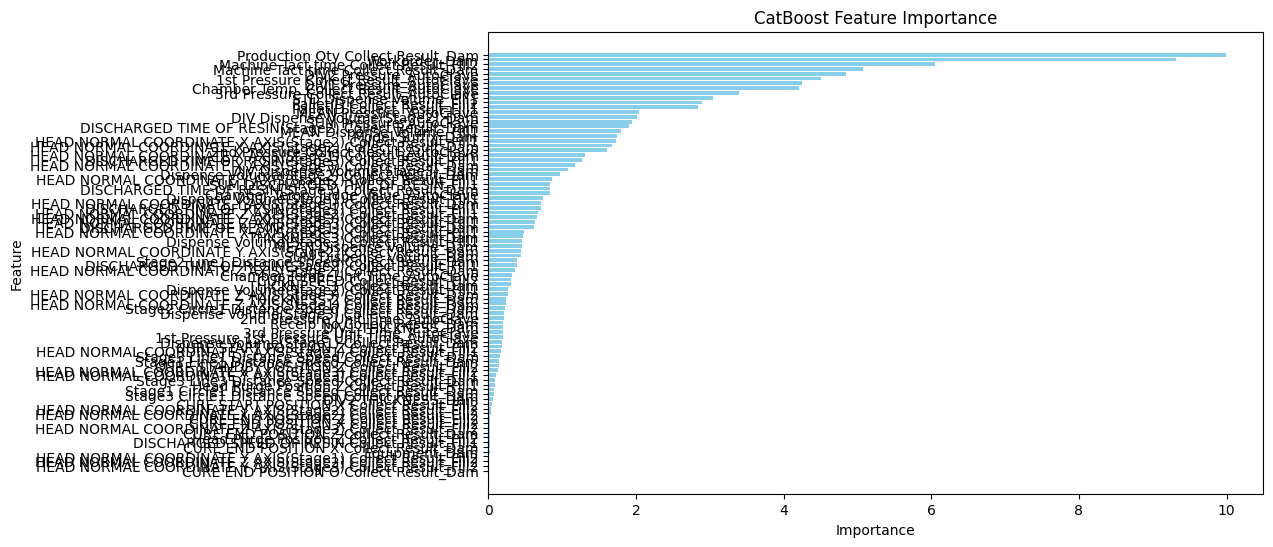

In [ ]:
# Feature Importance 계산
import matplotlib.pyplot as plt
feature_importances = model.get_feature_importance()

# Feature Importance를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': train_x.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Feature Importance 출력
print(feature_importance_df)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시되도록 축 반전
plt.show()

In [ ]:
feature_importance_df[:-3]

,Feature,Importance
22,Production Qty Collect Result_Dam,9.999212
2,Workorder_Dam,9.317698
73,Machine Tact time Collect Result_Fill2,6.043847
21,Machine Tact time Collect Result_Dam,5.080212
87,DIV2 Pressure_AutoClave,4.846237
...,...,...
72,Head Purge Position Z Collect Result_Fill2,0.021014
43,DISCHARGED SPEED OF RESIN Collect Result_Fill1,0.019094
3,CURE END POSITION X Collect Result_Dam,0.018745
0,Equipment_Dam,0.015887


In [ ]:
#re변경 케이스에 따라!!
feature_importance_df[-3:]['Feature'].unique() #확인

re=feature_importance_df[:-3]['Feature'].tolist()
train_x=train_x[re]
val_x=val_x[re]

In [ ]:
#성능 확인
model = CatBoostClassifier(learning_rate=0.1, verbose=False,cat_features=cat_features,auto_class_weights='Balanced')

model.fit(train_x,train_y)
pred_cat=model.predict(val_x)
print(classification_report(val_y,pred_cat))

from sklearn.metrics import f1_score

f1 = f1_score(val_y,pred_cat)
print('f1 score : ',f1)

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7631
           1       0.16      0.23      0.19       470

    accuracy                           0.88      8101
   macro avg       0.55      0.58      0.56      8101
weighted avg       0.91      0.88      0.89      8101

f1 score :  0.18659881255301106


## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
#test_x=test_df.drop(columns=['Set ID','target'])

sub=pd.read_csv('/content/drive/MyDrive/Aimers_생산불량/submission (1).csv')


In [ ]:
sub['target']=model.predict(test_x)
sub['target'].replace({0:'Normal',1:'AbNormal'},inplace=True)

sub['target'].value_counts()


,count
target,
Normal,14982
AbNormal,2379


In [ ]:
# 제출 파일 저장
sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
